### **Prediksi Suhu Rata-Rata menggunakan RNN**

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

**Prepare Data Testing**

In [97]:
test = pd.read_csv('data/test/apt-pranoto.csv', index_col='Tanggal', sep=";")
test.index = pd.to_datetime(test.index, format='%d-%m-%Y')
test = test.drop(['Tn', 'Tx', 'RH_avg', 'RR', 'ss', 'ff_x', 'ff_avg', 'ddd_car', 'ddd_x'], axis=1)
test = test.dropna()

print(len(test))
test.tail()

2894


,Tavg
Tanggal,
2020-12-27,27.2
2020-12-28,27.2
2020-12-29,26.2
2020-12-30,28.2
2020-12-31,26.6


#### **Train Test Split**

Coba prediksi data sebulan kedepan (30 hari)

In [98]:
train_set = test.head(2894-30)
test_set = test.tail(30)

In [99]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_set)
test_scaled = scaler.transform(test_set)

In [100]:
def next_batch(training_data, steps):
    rand_start = np.random.randint(0, len(training_data) - steps)
    y_batch = np.array(training_data[rand_start:rand_start + steps + 1]).reshape(1, steps + 1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1)

In [101]:
num_inputs = 1
num_time_steps = 30
num_neurons = 100
num_outputs = 1
learning_rate = 0.001
num_train_iterations = 10001

Buat placeholder tensorflow X sebagai input, dan y sebagai outputnya

In [102]:
input_layer = tf.keras.layers.Input(shape=(num_time_steps, num_inputs))
cell = tf.keras.layers.SimpleRNN(units=num_neurons, activation=tf.nn.relu, return_sequences=True)(
    input_layer)
output_layer = tf.keras.layers.Dense(num_outputs)(cell)

In [103]:
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate))

for iteration in range(num_train_iterations):
    X_batch, y_batch = next_batch(train_scaled, num_time_steps)
    model.train_on_batch(X_batch, y_batch)
    if iteration % 100 == 0:
        error = model.evaluate(X_batch, y_batch)
        print("iterasi ke -", iteration, "\t\tloss:", error)

model.save("models/prediksi_suhu_ratarata")

1/1 [==============================] - 0s 163ms/step - loss: 0.1118
iterasi ke - 0 		loss: 0.1118442565202713
1/1 [==============================] - 0s 62ms/step - loss: 0.0163
iterasi ke - 100 		loss: 0.016332918778061867
1/1 [==============================] - 0s 54ms/step - loss: 0.0189
iterasi ke - 200 		loss: 0.01894666627049446
1/1 [==============================] - 0s 60ms/step - loss: 0.0102
iterasi ke - 300 		loss: 0.010188460350036621
1/1 [==============================] - 0s 57ms/step - loss: 0.0066
iterasi ke - 400 		loss: 0.006568912882357836
1/1 [==============================] - 0s 54ms/step - loss: 0.0155
iterasi ke - 500 		loss: 0.015524250455200672
1/1 [==============================] - 0s 56ms/step - loss: 0.0084
iterasi ke - 600 		loss: 0.008351191878318787
1/1 [==============================] - 0s 53ms/step - loss: 0.0113
iterasi ke - 700 		loss: 0.01129123941063881
1/1 [==============================] - 0s 54ms/step - loss: 0.0211
iterasi ke - 800 		loss: 0.0211440

INFO:tensorflow:Assets written to: models/prediksi_suhu_ratarata/assets


In [104]:
model = tf.keras.models.load_model("models/prediksi_suhu_ratarata")
train_seed = np.array(train_scaled)

for iteration in range(30):
    X_batch = train_seed[-num_time_steps:].reshape(1, num_time_steps, 1)
    y_pred = model.predict(X_batch)
    train_seed = np.append(train_seed, y_pred[0, -1, 0])

1/1 [==============================] - 0s 55ms/step


In [105]:
train_seed

array([0.42528736, 0.36781609, 0.32183908, ..., 0.44797504, 0.44802976,
       0.44808382])

In [114]:
results = scaler.inverse_transform(np.array(train_seed[:30]).reshape(num_time_steps, 1))
test_set['Prediksi'] = results
test_set

/var/folders/_w/v4htfwfd40ggzfmlgw22dk2m0000gn/T/ipykernel_59552/4124513893.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['Prediksi'] = results


,Tavg,Prediksi
Tanggal,,
2020-12-02,26.4,27.8
2020-12-03,28.0,27.3
2020-12-04,28.2,26.9
2020-12-05,29.6,27.2
2020-12-06,29.4,27.0
2020-12-07,28.8,24.8
2020-12-08,28.5,27.0
2020-12-09,29.4,26.3
2020-12-10,27.8,26.6


<Axes: xlabel='Tanggal'>

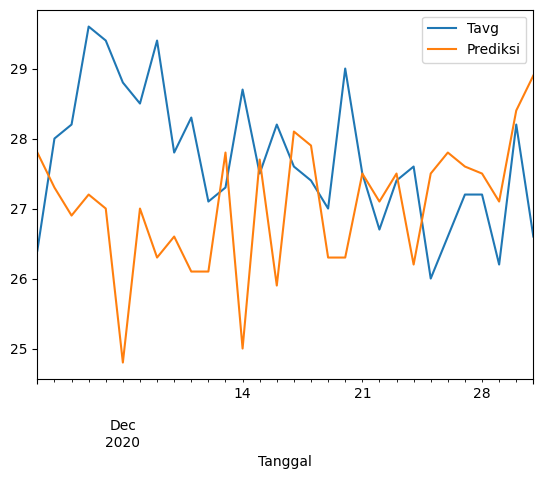

In [117]:
test_set.plot()